<h1>UnderSampling + Baggingでimbalancedなデータを学習</h1>


In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader , TensorDataset

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE 

import pandas as pd
import numpy as np

In [74]:
#データの読み込みとデータ処理
data_ =  pd.read_csv("./data/bank-additional-full.csv", sep=";").drop('duration',axis=1).drop('day_of_week',axis=1).sample(frac=1)
data_.y = data_.y.replace({'yes':1,'no':0})
print(data_.shape)
data_.head()

(41188, 19)


,age,job,marital,education,default,housing,loan,contact,month,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
35551,41,technician,single,high.school,no,yes,no,cellular,may,2,999,1,failure,-1.8,92.893,-46.2,1.244,5099.1,0
19368,59,housemaid,married,basic.4y,unknown,no,no,cellular,aug,2,999,0,nonexistent,1.4,93.444,-36.1,4.967,5228.1,0
34088,31,admin.,married,university.degree,no,yes,no,cellular,may,2,10,1,success,-1.8,92.893,-46.2,1.281,5099.1,1
2135,32,blue-collar,single,basic.9y,no,no,no,telephone,may,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
32456,34,technician,married,professional.course,no,no,no,cellular,may,2,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1,0


In [166]:
data = data_.copy()
data.pdays[data.pdays == 999] = 0
data.pdays[data.pdays != 0] = 1
data['month'].loc[(data['month'] == 'apr') | (data['month'] == 'may')| (data['month'] == 'jun')] = 'spr'
data['month'].loc[(data['month'] == 'jul') | (data['month'] == 'aug')| (data['month'] == 'sep')] = 'sum'
data['month'].loc[(data['month'] == 'oct') | (data['month'] == 'nov')| (data['month'] == 'dec')] = 'aut'
data['month'].loc[(data['month'] == 'jan') | (data['month'] == 'feb')| (data['month'] == 'mar')] = 'win'
data = data.drop('month',axis=1)
data.head()

/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setite

,age,job,marital,education,default,housing,loan,contact,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
35551,41,technician,single,high.school,no,yes,no,cellular,2,0,1,failure,-1.8,92.893,-46.2,1.244,5099.1,0
19368,59,housemaid,married,basic.4y,unknown,no,no,cellular,2,0,0,nonexistent,1.4,93.444,-36.1,4.967,5228.1,0
34088,31,admin.,married,university.degree,no,yes,no,cellular,2,1,1,success,-1.8,92.893,-46.2,1.281,5099.1,1
2135,32,blue-collar,single,basic.9y,no,no,no,telephone,2,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
32456,34,technician,married,professional.course,no,no,no,cellular,2,0,1,failure,-1.8,92.893,-46.2,1.313,5099.1,0


In [167]:
data['age'] = pd.cut(data['age'],[10,20,30,40,50,60,70,80,90,100],labels = ['10','20','30','40','50','60','70','80','90'])
data['nr.employed**2'] = data['nr.employed'] ** 2
data['euribor3m**2'] = data['euribor3m'] ** 2

data = pd.get_dummies(data)
data['Y'] = data['y']
data = data.drop('y',axis=1).drop('job_unknown',axis=1).drop('marital_unknown',axis=1).drop('education_unknown',axis=1).drop('default_unknown',axis=1).drop('housing_unknown',axis=1).drop('loan_unknown',axis=1)
#data['age'] = pd.cut(data['age'],[10,20,30,40,50,60,70,80,90,100],labels = [10,20,30,40,50,60,70,80,90])


data.head(3)

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,nr.employed**2,euribor3m**2,...,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,Y
35551,2,0,1,-1.8,92.893,-46.2,1.244,5099.1,26000820.81,1.547536,...,0,1,1,0,1,0,1,0,0,0
19368,2,0,0,1.4,93.444,-36.1,4.967,5228.1,27333029.61,24.671089,...,1,0,1,0,1,0,0,1,0,0
34088,2,1,1,-1.8,92.893,-46.2,1.281,5099.1,26000820.81,1.640961,...,0,1,1,0,1,0,0,0,1,1


In [168]:
data.head(10)

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,nr.employed**2,euribor3m**2,...,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,Y
35551,2,0,1,-1.8,92.893,-46.2,1.244,5099.1,26000820.81,1.547536,...,0,1,1,0,1,0,1,0,0,0
19368,2,0,0,1.4,93.444,-36.1,4.967,5228.1,27333029.61,24.671089,...,1,0,1,0,1,0,0,1,0,0
34088,2,1,1,-1.8,92.893,-46.2,1.281,5099.1,26000820.81,1.640961,...,0,1,1,0,1,0,0,0,1,1
2135,2,0,0,1.1,93.994,-36.4,4.857,5191.0,26946481.00,23.590449,...,1,0,1,0,0,1,0,1,0,0
32456,2,0,1,-1.8,92.893,-46.2,1.313,5099.1,26000820.81,1.723969,...,1,0,1,0,1,0,1,0,0,0
40068,1,0,0,-1.7,94.215,-40.3,0.810,4991.6,24916070.56,0.656100,...,1,0,1,0,0,1,0,1,0,0
21685,1,0,0,1.4,93.444,-36.1,4.963,5228.1,27333029.61,24.631369,...,1,0,1,0,1,0,0,1,0,0
219,3,0,0,1.1,93.994,-36.4,4.857,5191.0,26946481.00,23.590449,...,1,0,1,0,0,1,0,1,0,0
38555,2,0,0,-3.4,92.431,-26.9,0.722,5017.5,25175306.25,0.521284,...,1,0,1,0,1,0,0,1,0,0
4261,5,0,0,1.1,93.994,-36.4,4.856,5191.0,26946481.00,23.580736,...,1,0,0,1,0,1,0,1,0,0


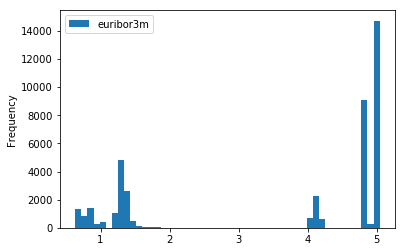

In [169]:
%matplotlib inline
import matplotlib.pyplot as plt

pd.DataFrame(data['euribor3m']).plot(kind='hist',bins=50)

In [170]:
data['emp.var.rate'] = pd.cut(data['emp.var.rate'],[-4,-3,-2,-1,0,1,2],labels = [-3,-2,-1,0,1,2])
#data['cons.conf.idx'] = pd.cut(data['cons.conf.idx'],[-60,-45,-35,0],labels = [-50,-40,-30])
#data['nr.employed'] = pd.cut(data['nr.employed'],[4950,5050,5150,6000],labels = [5000,5100,5200])
#data['euribor3m'] = pd.cut(data['euribor3m'],[0,3,6],labels = [1,4.5])


data

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,nr.employed**2,euribor3m**2,...,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,Y
35551,2,0,1,-1,92.893,-46.2,1.244,5099.1,26000820.81,1.547536,...,0,1,1,0,1,0,1,0,0,0
19368,2,0,0,2,93.444,-36.1,4.967,5228.1,27333029.61,24.671089,...,1,0,1,0,1,0,0,1,0,0
34088,2,1,1,-1,92.893,-46.2,1.281,5099.1,26000820.81,1.640961,...,0,1,1,0,1,0,0,0,1,1
2135,2,0,0,2,93.994,-36.4,4.857,5191.0,26946481.00,23.590449,...,1,0,1,0,0,1,0,1,0,0
32456,2,0,1,-1,92.893,-46.2,1.313,5099.1,26000820.81,1.723969,...,1,0,1,0,1,0,1,0,0,0
40068,1,0,0,-1,94.215,-40.3,0.810,4991.6,24916070.56,0.656100,...,1,0,1,0,0,1,0,1,0,0
21685,1,0,0,2,93.444,-36.1,4.963,5228.1,27333029.61,24.631369,...,1,0,1,0,1,0,0,1,0,0
219,3,0,0,2,93.994,-36.4,4.857,5191.0,26946481.00,23.590449,...,1,0,1,0,0,1,0,1,0,0
38555,2,0,0,-3,92.431,-26.9,0.722,5017.5,25175306.25,0.521284,...,1,0,1,0,1,0,0,1,0,0
4261,5,0,0,2,93.994,-36.4,4.856,5191.0,26946481.00,23.580736,...,1,0,0,1,0,1,0,1,0,0


In [172]:
data_.describe(include='all')
data.corr()

,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,nr.employed**2,euribor3m**2,age_10,...,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,Y
campaign,1.000000,-0.051955,-0.079141,0.127836,-0.013733,0.135133,0.144095,0.144469,0.140117,-0.009407,...,0.010959,-0.010800,-0.004831,0.005294,-0.077368,0.077368,-0.068890,0.087645,-0.050893,-0.066357
pdays,-0.051955,1.000000,0.583103,-0.079344,0.091934,-0.295913,-0.371254,-0.369643,-0.276456,0.053224,...,-0.008641,0.009144,0.000884,-0.000196,0.117864,-0.117864,-0.005474,-0.488826,0.944373,0.323029
previous,-0.079141,0.583103,1.000000,-0.203130,-0.050936,-0.454494,-0.501333,-0.500307,-0.444654,0.063037,...,-0.021677,0.020446,0.000504,-0.002143,0.212848,-0.212848,0.682608,-0.878776,0.524045,0.230181
cons.price.idx,0.127836,-0.079344,-0.203130,1.000000,0.058986,0.688230,0.522034,0.525287,0.708525,-0.038603,...,0.077170,-0.081920,-0.000982,-0.005944,-0.591474,0.591474,-0.297718,0.304264,-0.077416,-0.136211
cons.conf.idx,-0.013733,0.091934,-0.050936,0.058986,1.000000,0.277686,0.100513,0.102347,0.320395,0.009551,...,0.032388,-0.034496,0.009975,-0.013673,-0.251614,0.251614,-0.162592,0.099724,0.084824,0.054878
euribor3m,0.135133,-0.295913,-0.454494,0.688230,0.277686,1.000000,0.945154,0.946389,0.996264,-0.075309,...,0.058233,-0.058913,-0.000697,-0.000487,-0.399773,0.399773,-0.385417,0.488406,-0.281022,-0.307771
nr.employed,0.144095,-0.371254,-0.501333,0.522034,0.100513,0.945154,1.000000,0.999978,0.929741,-0.082156,...,0.045590,-0.045046,-0.003458,0.004205,-0.269155,0.269155,-0.349602,0.493051,-0.350613,-0.354678
nr.employed**2,0.144469,-0.369643,-0.500307,0.525287,0.102347,0.946389,0.999978,1.000000,0.931319,-0.082015,...,0.045676,-0.045138,-0.003438,0.004176,-0.268879,0.268879,-0.350330,0.492919,-0.349126,-0.353616
euribor3m**2,0.140117,-0.276456,-0.444654,0.708525,0.320395,0.996264,0.929741,0.931319,1.000000,-0.071823,...,0.060694,-0.061629,-0.000655,-0.000900,-0.408051,0.408051,-0.393699,0.486281,-0.262918,-0.292001
age_10,-0.009407,0.053224,0.063037,-0.038603,0.009551,-0.075309,-0.082156,-0.082015,-0.071823,1.000000,...,-0.011145,0.010576,-0.002628,0.002050,0.024375,-0.024375,0.018573,-0.043587,0.051898,0.054396


In [173]:
clf_rf = RandomForestClassifier()
clf_rf.fit(data.iloc[:,:-1],data.iloc[:,-1])
fti = clf_rf.feature_importances_   
for i, feat in enumerate(data.columns):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))
    if i == len(data.columns)-2:
        break

	campaign             : 0.114439
	pdays                : 0.017049
	previous             : 0.013987
	emp.var.rate         : 0.014522
	cons.price.idx       : 0.023086
	cons.conf.idx        : 0.027382
	euribor3m            : 0.129470
	nr.employed          : 0.079447
	nr.employed**2       : 0.008058
	euribor3m**2         : 0.108419
	age_10               : 0.001703
	age_20               : 0.015884
	age_30               : 0.018988
	age_40               : 0.015102
	age_50               : 0.013890
	age_60               : 0.004922
	age_70               : 0.003029
	age_80               : 0.001262
	age_90               : 0.000123
	job_admin.           : 0.018069
	job_blue-collar      : 0.013300
	job_entrepreneur     : 0.006595
	job_housemaid        : 0.005023
	job_management       : 0.010108
	job_retired          : 0.008107
	job_self-employed    : 0.007501
	job_services         : 0.011656
	job_student          : 0.005787
	job_technician       : 0.017710
	job_unemployed       : 0.005490
	marital_d

In [174]:
# データを訓練データと評価データに分割
train_data = data[:int(len(data)*0.7)]
test_data = data[int(len(data)*0.7):]

train_data.shape

(28831, 52)

In [175]:
# 訓練データを少数クラスのデータと多数クラスに分割
train_data_1 = train_data[train_data['Y'] == 1]
train_data_0 = train_data[train_data['Y'] == 0]

In [176]:
# yが 1 なのは全体の1/10くらい
len(train_data_1)/len(train_data)

0.11237903645381707

<h2>ニューラルネットワークモデル定義</h2>
<h4>GridSearchCVとかPipelineが便利なので、sklearnのBaseEstimatorを継承しました</h4>

In [177]:
from sklearn.base import BaseEstimator
from sklearn.base import BaseEstimator, ClassifierMixin

OUTPUT_SIZE=2

class skNN(BaseEstimator,nn.Module,ClassifierMixin):
    def __init__(self, input_layer=20,hidden_layer=20,lr=0.01):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.lr = lr
        
        super(skNN, self).__init__()
        self.fc1 = nn.Linear(self.input_layer,self.hidden_layer)
        self.fc2 = nn.Linear(self.hidden_layer,self.hidden_layer)
        self.fc3 = nn.Linear(self.hidden_layer,OUTPUT_SIZE)
        self.outact = nn.Softmax()
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(),lr=self.lr)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x)
        x = self.fc3(x)
        return self.outact(x)
        
    def fit(self, X, y=None, **params):
        self.input_layer = len(X[0])
        self.fc1 = nn.Linear(self.input_layer,self.hidden_layer)
        
        tensorX = torch.from_numpy(X).float()
        tensorY = torch.from_numpy(y).long()
        train = TensorDataset(tensorX,tensorY)
        train_loader = DataLoader(train, batch_size=32, shuffle=True)

        for epoch in range(int(len(X)/32)):
            total_loss = 0    
            for train_x, train_y in train_loader:
                train_x, train_y = Variable(train_x), Variable(train_y)
                self.optimizer.zero_grad()
                output = self(train_x)
                loss = self.criterion(output, train_y)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.data[0]
            
            if (epoch+1) % 50 == 0:
                print(epoch+1, total_loss)
        return self
    
    def predict(self, X):
        tensorX = torch.from_numpy(X).float()
        test_X = Variable(tensorX)
        return (self(test_X).data[:,1].numpy() > 0.5).astype(int)
    
    def predict_proba(self, X):
        tensorX = torch.from_numpy(X).float()
        test_X = Variable(tensorX)
        return self(test_X).data[:,1].numpy()
    
    def score(self,X,y):
        tensorX = torch.from_numpy(X).float()
        test_X = Variable(tensorX)
        return sum( (self(test_X).data[:,1].numpy() > 0.5).astype(int) == y )/ len(y)
    
    def get_params(self,deep=True):
        return {'hidden_layer': self.hidden_layer, 'lr': self.lr}
    
    def set_params(self,**params):
        for parameter, value in params.items():
            setattr(self,parameter, value)
        self.fc1 = nn.Linear(self.input_layer,self.hidden_layer)
        self.fc2 = nn.Linear(self.hidden_layer,self.hidden_layer)
        self.fc3 = nn.Linear(self.hidden_layer,OUTPUT_SIZE)
        self.optimizer = optim.Adam(self.parameters(),lr=self.lr)
        return self
        

<h2>学習実行</h2>
<h4>折角なので色んな種類の識別器を使ってみます。それぞれでグリッドサーチし、最適なパラメータを探索しています</h4>

In [178]:
# 識別器の定義
from sklearn.linear_model import LogisticRegression
from sklearn import svm
clfs = {"GB1":GradientBoostingClassifier(),
        "GB2":GradientBoostingClassifier(),
        "GB3":GradientBoostingClassifier(),
        "GB4":GradientBoostingClassifier(),
        "GB5":GradientBoostingClassifier(),
        "GB6":GradientBoostingClassifier(),
        "GB7":GradientBoostingClassifier(),
        "GB8":GradientBoostingClassifier()
        #"NN":skNN()
       }


In [179]:
# 各Estimatorのパラメータ探索用dict
gb_parameters = {
    "select__threshold" : ["mean", "median"],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth":[7,9],
    "clf__subsample":[0.5, 1.0],
    "clf__n_estimators":[10]
}
rf_parameters = {
    "clf__n_estimators" : [100],
    "clf__max_features" : [1, 'auto', None],
    "clf__max_depth" : [1, 5, 10, None],
    "clf__min_samples_leaf": [1, 2, 4,]
}
lr_parameters = {
    "clf__C": [0.01,0.1,1]
}
svc_parameters = {
    "clf__C": [1,10,100],
    "clf__gamma": [0.01,0.1,1]
}
nn_parameters = {
    "select__threshold" : ["mean", "median"],
    "clf__hidden_layer": [30,40,50],
    "clf__lr": [0.01],
}

In [180]:
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline 
i=0

# 識別器格納用リスト
# 8種類の識別器が格納される
gb_clfs = []

# 各識別器に対して学習実行
for clf in clfs.items():
    i += 1
    print(i) 
    
    # 多数データを少数データの数だけUnderSamplingし、少数データとマージ
    train_data_ = np.vstack((train_data_0.sample(n=int(8*len(train_data_1))),train_data_1.sample(n=int(len(train_data_1)))))
    # マージ後の訓練データをシャッフル
    np.random.shuffle(train_data_)
    # 訓練データを説明変数と目的変数に分割
    train_data_feature = train_data_[:,:-1].astype(float)
    train_data_target = train_data_[:,-1].astype(float)
    
    # 説明変数(特徴量)抽出モデルと標準化モデルを定義
    select = SelectFromModel(RandomForestClassifier(n_estimators=100, n_jobs=-1))
    pca = PCA()
    sm = SMOTE()
    scaler = StandardScaler()
    
    # 一連の処理(Pipeline)を定義
    # 特徴量抽出→標準化→識別器訓練
    estimator = [
        ('select',select),
        #('pca',pca),
        ('smote' ,sm),
        ('scaler',scaler),
        ('clf',clf[1])
    ]

    pipe = Pipeline(estimator)
    
    # グリッドサーチ用モデルの定義
    # 識別器の種類によってパラメータが異なるので条件分岐
    if clf[0] == 'SVC':
        gb_clf = GridSearchCV(pipe, svc_parameters, scoring='f1', cv=3, n_jobs=2)
    elif clf[0] == 'RF':
        gb_clf = GridSearchCV(pipe, rf_parameters, scoring='f1', cv=3, n_jobs=2)
    elif clf[0] =='NN':
        gb_clf = GridSearchCV(pipe, nn_parameters, scoring='f1', cv=3, n_jobs=2)
    elif clf[0].find('LR') > -1:
        gb_clf = GridSearchCV(pipe, lr_parameters, scoring='f1', cv=3, n_jobs=2)
    else:
        gb_clf = GridSearchCV(pipe, gb_parameters, scoring='f1', cv=3, n_jobs=2)

    # グリッドサーチ実行
    gb_clf.fit(train_data_feature,train_data_target)
    
    # 最適なパラメータで訓練された識別器をリストに追加
    gb_clfs.append(gb_clf)

1
2
3
4
5
6
7
8


<h2>評価</h2>

In [181]:
sum(train_data_[:,-1] == 0)

12960

In [182]:
# 評価データを説明変数と目的変数に分割
test_data_feature = test_data.iloc[:,:-1]
test_data_target = test_data.iloc[:,-1]

# 投票箱作成
predict_vote=np.zeros(int(len(test_data_feature)))

# 各識別器の予測結果を投票箱に入れる
for gb_clf in gb_clfs:
    predict_vote += (gb_clf.predict(test_data_feature))
    
# 投票結果は多数決    
predict_vote = (predict_vote/8 > 0.5).astype(int)
predict_vote

array([0, 0, 0, ..., 0, 0, 0])

In [183]:
predict_vote.shape

(12357,)

In [184]:
# F値確認
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

print(f1_score(predict_vote,test_data_target))
confusion_matrix(predict_vote,test_data_target)

0.508300633867


array([[9886,  558],
       [1071,  842]])

In [185]:
for clf in gb_clfs:
    print(clf.best_params_)

{'clf__learning_rate': 0.05, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 0.5, 'select__threshold': 'median'}
{'clf__learning_rate': 0.05, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 0.5, 'select__threshold': 'mean'}
{'clf__learning_rate': 0.05, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 0.5, 'select__threshold': 'median'}
{'clf__learning_rate': 0.01, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 0.5, 'select__threshold': 'median'}
{'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 1.0, 'select__threshold': 'median'}
{'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 0.5, 'select__threshold': 'median'}
{'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 0.5, 'select__threshold': 'median'}
{'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 10, 'clf__subsample': 1.0, 'sele

In [186]:
for clf in gb_clfs:
    print(f1_score(test_data_target,clf.predict(test_data_feature)))

0.499233363999
0.478789516347
0.500747831289
0.501694915254
0.500447360573
0.501811594203
0.506740196078
0.500893388922


<h2>単純に勾配ブースティング</h2>
<h4>以下、比較のため単体での学習・評価を実行</h4>

In [187]:
train_data_ = np.vstack((train_data_0,train_data_1))
# マージ後の訓練データをシャッフル
np.random.shuffle(train_data_)
# 訓練データを説明変数と目的変数に分割
train_data_feature = train_data_[:,:-1].astype(float)
train_data_target = train_data_[:,-1].astype(float)

In [188]:
mono_gb = GradientBoostingClassifier()

In [189]:
train_data_.shape

(28831, 52)

In [190]:
from imblearn.pipeline import Pipeline 
select = SelectFromModel(RandomForestClassifier(n_estimators=100, n_jobs=-1))
sm = SMOTE()
scaler = StandardScaler()
estimator = [
    ('select',select),
    ('smote' ,sm),
    ('scaler',scaler),
    ('clf',mono_gb)
]

pipe = Pipeline(estimator)

mono_gb_clf = GridSearchCV(pipe, gb_parameters, cv=3, n_jobs=-1)
mono_gb_clf.fit(train_data_feature,train_data_target)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_sp...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'select__threshold': ['mean', 'median'], 'clf__learning_rate': [0.01, 0.05, 0.1], 'clf__max_depth': [7, 9], 'clf__subsample': [0.5, 1.0], 'clf__n_estimators': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [191]:
mono_gb_predict = mono_gb_clf.predict(test_data_feature)

In [192]:
mono_gb_clf.best_params_

{'clf__learning_rate': 0.1,
 'clf__max_depth': 9,
 'clf__n_estimators': 10,
 'clf__subsample': 0.5,
 'select__threshold': 'median'}

In [194]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

print(f1_score(test_data_target,mono_gb_clf.predict(test_data_feature)))
confusion_matrix(test_data.iloc[:,-1], mono_gb_predict)

0.48347245409


array([[10086,   871],
       [  676,   724]])

<h2>単純にニューラルネットワーク</h2>

In [197]:
model=skNN(hidden_layer=30,lr=0.01)

In [198]:
model=skNN(hidden_layer=30,lr=0.1)
select = SelectFromModel(RandomForestClassifier(n_estimators=100, n_jobs=-1))
sm = SMOTE()
scaler = StandardScaler()
estimator = [
    ('select',select),
    ('smote',sm),
    ('scaler',scaler),
    ('clf',model)
]

pipe = Pipeline(estimator)

In [199]:
#nn_params = {
#        'clf__hidden_layer': [30,40,50,60],
#        'clf__lr': [0.01,0.05],
#    }
grid_search = GridSearchCV(pipe,param_grid=nn_parameters,cv=3,n_jobs=-1)
grid_search.fit(train_data_feature,train_data_target)

/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension ch

50 tensor(557.8391)
50 tensor(543.9849)
50 tensor(527.2307)
50 tensor(570.3547)
100 tensor(550.8557)
100 tensor(536.5461)
100 tensor(515.6543)
100 tensor(564.2882)
150 tensor(548.6052)
150 tensor(513.3145)
150 tensor(531.6721)
150 tensor(562.6512)
200 tensor(547.1816)
200 tensor(509.6516)
200 tensor(529.5917)
200 tensor(559.7216)
250 tensor(544.7672)
250 tensor(509.3481)
250 tensor(527.6370)
250 tensor(558.6257)
300 tensor(543.1256)
300 tensor(506.4181)
300 tensor(525.8132)
300 tensor(558.0879)
350 tensor(542.0827)
350 tensor(503.8922)
350 tensor(525.3711)
350 tensor(556.7156)
400 tensor(541.8386)
400 tensor(507.3450)
400 tensor(524.7877)
400 tensor(555.4424)
450 tensor(504.1649)
450 tensor(540.9223)
450 tensor(521.9892)
450 tensor(559.8221)
500 tensor(502.7435)
500 tensor(539.2355)
500 tensor(523.2221)
500 tensor(554.9557)
550 tensor(540.0178)
550 tensor(503.9262)
550 tensor(522.0019)
550 tensor(554.3182)
600 tensor(501.7488)
600 tensor(538.4344)
600 tensor(552.6016)
600 tensor(522.22

/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension ch

50 tensor(535.5482)
50 tensor(529.7491)
50 tensor(534.4808)
50 tensor(563.0657)
100 tensor(529.0225)
100 tensor(521.0278)
100 tensor(528.0087)
100 tensor(555.0027)
150 tensor(526.8080)
150 tensor(520.1213)
150 tensor(523.4920)
150 tensor(551.0811)
200 tensor(523.2461)
200 tensor(515.5953)
200 tensor(522.1714)
200 tensor(547.9902)
250 tensor(522.2963)
250 tensor(515.8629)
250 tensor(518.0310)
250 tensor(548.4808)
300 tensor(520.0507)
300 tensor(513.8779)
300 tensor(519.1062)
300 tensor(546.4342)
350 tensor(521.0500)
350 tensor(510.3816)
350 tensor(516.6136)
350 tensor(545.4495)
400 tensor(521.4919)
400 tensor(512.0970)
400 tensor(516.9042)
400 tensor(545.5073)
450 tensor(518.6243)
450 tensor(511.8549)
450 tensor(514.1530)
450 tensor(544.4266)
500 tensor(517.7375)
500 tensor(511.6259)
500 tensor(513.8364)
500 tensor(542.0010)
550 tensor(518.1789)
550 tensor(508.8085)
550 tensor(512.9071)
550 tensor(542.0039)
600 tensor(518.5060)
600 tensor(511.0445)
600 tensor(512.8193)
600 tensor(541.47

/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


1050 tensor(512.1454)


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


1050 tensor(539.1945)
50 tensor(547.0770)


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


50 tensor(509.7193)
50 tensor(507.9737)
100 tensor(539.8561)
50 tensor(510.0303)
100 tensor(501.9473)
100 tensor(497.2476)
150 tensor(535.3578)
100 tensor(495.9499)
150 tensor(496.9405)
150 tensor(493.1043)
200 tensor(533.0767)
150 tensor(490.9077)
200 tensor(495.4081)
200 tensor(489.6184)
250 tensor(533.0011)
200 tensor(488.0449)
250 tensor(492.2265)
250 tensor(488.2046)
300 tensor(530.0009)
250 tensor(488.8498)
300 tensor(494.1454)
300 tensor(488.4705)
350 tensor(532.1616)
300 tensor(484.4226)
350 tensor(489.8900)
350 tensor(484.4921)
350 tensor(484.9754)
400 tensor(534.0778)
400 tensor(490.2692)
400 tensor(485.8794)
400 tensor(481.8301)
450 tensor(531.8831)
450 tensor(488.3365)
450 tensor(484.2057)
450 tensor(484.5087)
500 tensor(528.1302)
500 tensor(489.4219)
500 tensor(483.4813)
500 tensor(483.1505)
550 tensor(529.5995)
550 tensor(487.4379)
550 tensor(482.9904)
550 tensor(482.6065)
600 tensor(531.3232)
600 tensor(487.5041)
600 tensor(483.3410)
600 tensor(482.1976)
650 tensor(528.8

/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


1050 tensor(480.2800)


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


1050 tensor(475.6504)


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


50 tensor(532.6033)
50 tensor(563.8830)
50 tensor(548.4990)
50 tensor(501.7575)
100 tensor(523.1863)
100 tensor(558.2603)
100 tensor(539.8250)
100 tensor(490.8505)
150 tensor(519.5275)
150 tensor(556.2327)
150 tensor(536.3959)
150 tensor(484.4746)
200 tensor(515.6801)
200 tensor(554.2245)
200 tensor(534.2622)
200 tensor(481.4880)
250 tensor(515.3901)
250 tensor(552.8917)
250 tensor(533.2504)
250 tensor(476.8568)
300 tensor(513.4420)
300 tensor(551.8760)
300 tensor(530.8460)
300 tensor(475.1172)
350 tensor(511.3195)
350 tensor(551.4733)
350 tensor(530.7645)
350 tensor(474.2321)
400 tensor(512.0309)
400 tensor(548.9702)
400 tensor(530.8932)
400 tensor(471.0918)
450 tensor(512.0400)
450 tensor(548.3156)
450 tensor(529.0721)
450 tensor(470.6183)
500 tensor(510.3999)
500 tensor(549.0218)
500 tensor(529.7354)
500 tensor(475.4194)
550 tensor(510.7562)
550 tensor(548.6691)
550 tensor(529.1590)
550 tensor(469.6800)
600 tensor(509.5078)
600 tensor(547.8956)
600 tensor(527.6919)
600 tensor(469.91

/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


1050 tensor(525.7833)
1050 tensor(466.0893)
50 tensor(515.0069)
50 tensor(503.4022)
100 tensor(500.9402)
100 tensor(491.8915)
150 tensor(496.0464)
150 tensor(487.2985)
200 tensor(494.5227)
200 tensor(483.7028)
250 tensor(494.3641)
250 tensor(481.4759)
300 tensor(494.6774)
300 tensor(477.0828)
350 tensor(491.5164)
350 tensor(478.3790)
400 tensor(490.4348)
400 tensor(476.8471)
450 tensor(488.8199)
450 tensor(476.0746)
500 tensor(490.2078)
500 tensor(474.8454)
550 tensor(493.0159)
550 tensor(472.5151)
600 tensor(488.5540)
600 tensor(474.8416)
650 tensor(487.0791)
650 tensor(473.9813)
700 tensor(490.2062)
700 tensor(473.5650)
750 tensor(486.6699)
750 tensor(473.0753)
800 tensor(489.5146)
800 tensor(470.6731)
850 tensor(488.1471)
850 tensor(470.0028)
900 tensor(490.9068)
900 tensor(471.3318)
950 tensor(486.5172)
950 tensor(474.2051)
1000 tensor(488.3627)
1000 tensor(471.1871)
1050 tensor(488.2065)
1050 tensor(469.3315)


/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


50 tensor(772.5349)
100 tensor(754.7589)
150 tensor(746.6490)
200 tensor(746.3022)
250 tensor(741.6332)
300 tensor(735.8154)
350 tensor(738.6591)
400 tensor(738.0126)
450 tensor(735.6474)
500 tensor(733.9800)
550 tensor(731.2554)
600 tensor(737.7261)
650 tensor(735.4512)
700 tensor(731.5216)
750 tensor(731.7388)
800 tensor(729.7098)
850 tensor(729.4766)
900 tensor(732.9983)
950 tensor(733.1875)
1000 tensor(732.0147)
1050 tensor(729.7910)
1100 tensor(728.6412)
1150 tensor(734.2595)
1200 tensor(730.8818)
1250 tensor(726.2118)
1300 tensor(729.9189)
1350 tensor(731.3743)
1400 tensor(730.4963)
1450 tensor(732.1171)
1500 tensor(728.1081)
1550 tensor(724.7798)


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_sp..., StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', skNN(hidden_layer=30, lr=0.1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'select__threshold': ['mean', 'median'], 'clf__hidden_layer': [30, 40, 50], 'clf__lr': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [200]:
grid_search.best_params_

{'clf__hidden_layer': 50, 'clf__lr': 0.01, 'select__threshold': 'median'}

In [201]:
nn_predicted = grid_search.predict(test_data_feature)
sum(nn_predicted == test_data_target) / len(test_data_target)

/Users/GenseiYoshimura/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.80351217933155294

In [202]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

print(f1_score(test_data_target,nn_predicted))
confusion_matrix(test_data_target, nn_predicted)

0.393


array([[9143, 1814],
       [ 614,  786]])